### Model Interpretation for Pretrained Deep Learning Models

This notebook demonstrates how to apply model interpretability algorithms on pretrained deep learning models (ResNet, VGG) using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are `Integrated Gradients` (w/ and w/o noise tunnel),  `GradientShap`, `Occlusion`, and `LRP`. A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.

Import libraries

In [1]:
import torch
import torch.nn.functional as F

from PIL import Image
import requests
from io import BytesIO


import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP, DeepLift
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

## 1- Loading the model and the dataset


In [2]:
# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")  # Force CPU for this example

In [3]:
# Loads pretrained Resnet model and sets it to eval mode
def load_model():
    model = models.resnet50(pretrained=True)
    model.eval()
    model.to(device)
    return model

model = load_model()

/home/seham/miniconda3/envs/hcxai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/seham/miniconda3/envs/hcxai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Downloads the list of classes/labels for ImageNet dataset and reads them into the memory
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2025-07-21 21:31:12--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.217.152, 16.15.185.90, 16.15.217.221, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.217.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/home/seham/.torch/models/imagenet_class_index.json.10’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.1s    

2025-07-21 21:31:13 (300 KB/s) - ‘/home/seham/.torch/models/imagenet_class_index.json.10’ saved [35363/35363]



In [5]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [6]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

# Sample image
# Load image from URL
url = "https://upload.wikimedia.org/wikipedia/commons/2/26/YellowLabradorLooking_new.jpg"
response = requests.get(url)
orig_img = Image.open(BytesIO(response.content)).convert('RGB')

# Apply transforms
transformed_img = transform(orig_img)
normalized_img = transform_normalize(transformed_img)

# Add batch dimension
input = normalized_img.unsqueeze(0)
input = input.to(device)

Predict the class

In [7]:
output = model(input)
output = output.to(device)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: Labrador_retriever ( 0.5235468745231628 )


## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [8]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

Predicted: Labrador_retriever ( 0.5235468745231628 )


Let's visualize the image and corresponding attributions by overlaying the latter on the image.

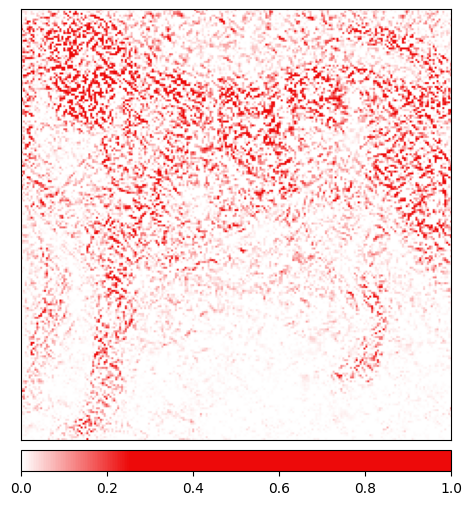

In [9]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, "#ED0A0A"),
                                                  (1, '#ED0A0A')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

 ## 2- LRP-based attribution

Now let's try a different approach called Layer-Wise Relevance Propagation (LRP). It uses a backward propagation mechanism applied sequentially to 
all layers of the model, to see which neurons contributed to the output. The output score of LRP represents the relevance, decomposed into values for each layer. 
The decomposition is defined by rules that may vary for each layer. 

Initially, we apply a direct implementation of LRP attribution. The default Epsilon-Rule is used for each layer. 

Note: We use the VGG16 model instead here since the default rules for LRP are not fine-tuned for ResNet currently.

In [10]:
model = models.vgg16(pretrained=True)
model.eval()
model.to(device)
lrp = LRP(model)

attributions_lrp = lrp.attribute(input.to(device), 
                                target=pred_label_idx)

/home/seham/miniconda3/envs/hcxai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/seham/miniconda3/envs/hcxai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/seham/miniconda3/envs/hcxai/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

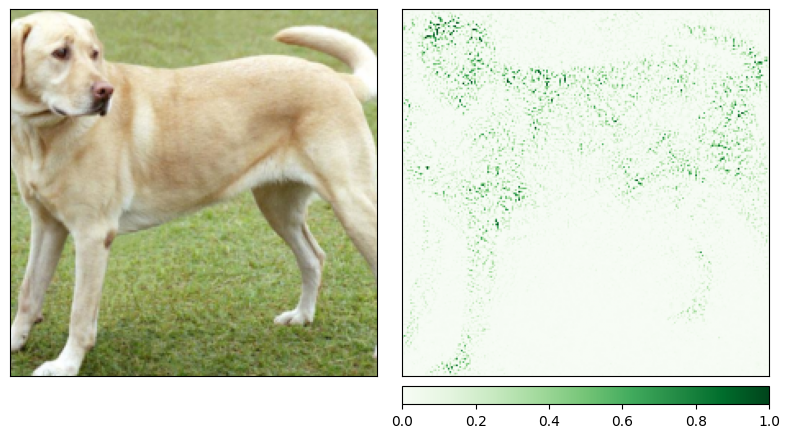

In [11]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

# 3- DeepLift attribution

Implements DeepLIFT algorithm based on the following paper: Learning Important Features Through Propagating Activation Differences, Avanti Shrikumar, et. al. https://arxiv.org/abs/1704.02685


and the gradient formulation proposed in: Towards better understanding of gradient-based attribution methods for deep neural networks, Marco Ancona, et.al. https://openreview.net/pdf?id=Sy21R9JAW




In [ ]:
model = models.vgg16(pretrained=True)
model.eval()
model.to(device)
deeplift = DeepLift(model) 

/home/seham/miniconda3/envs/hcxai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/seham/miniconda3/envs/hcxai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/seham/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [01:00<00:00, 9.52MB/s] 


In [35]:
input = torch.randn(2, 3, 32, 32, requires_grad=True)
attribution_dl = deeplift.attribute(input.to(device), target=3)

/home/seham/miniconda3/envs/hcxai/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [36]:
def prepare_for_viz(tensor):
    """
    Converts PyTorch tensor [C, H, W] or [H, W] to NumPy [H, W, C] or [H, W].
    Removes batch/channel dims if needed.
    """
    arr = tensor.detach().cpu().numpy()
    if arr.ndim == 4:  # [B, C, H, W]
        arr = arr[0]   # Take first batch
    if arr.ndim == 3:  # [C, H, W]
        arr = np.transpose(arr, (1, 2, 0))  # [H, W, C]
    if arr.ndim == 2:  # [H, W]
        pass  # Already fine
    return arr


In [37]:
attr = prepare_for_viz(attribution_dl)
img = prepare_for_viz(transformed_img)



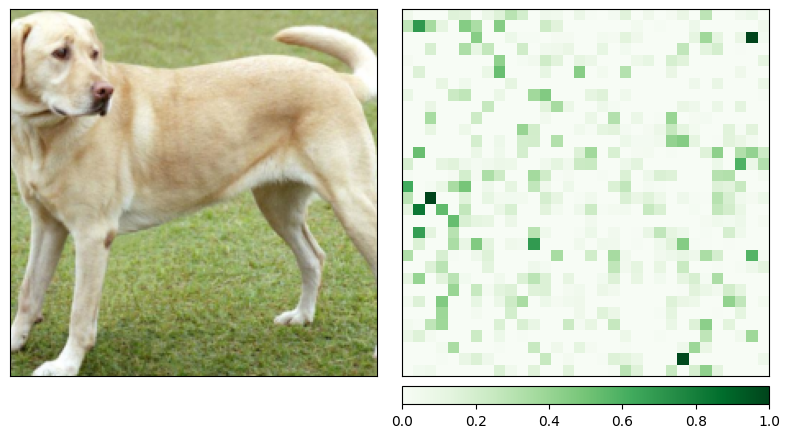

In [38]:
_ = viz.visualize_image_attr_multiple(
    attr,
    img,
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2
)
